In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
os.chdir("/Users/amirrezasokhankhosh/Documents/Workstation/testing_adult/privacy/")
from privacy.encode import encodeData, encodeNonAnonData
os.chdir("/Users/amirrezasokhankhosh/Documents/Workstation/testing_adult/")

In [9]:
data = "texas"
method = "classic_mondrian"
k_list = [5, 100, 200, 500]

In [10]:
class Mondrian_Utility:
    def __init__(self, data, method, k_list):
        self.data = data
        self.method = method
        self.k_list = k_list
    
    def anonymize(self):
        for k in self.k_list:
            os.system(f'python privacy/anonymize.py --method={self.method} --k={k} --dataset={self.data}')
    
    def get_features(self):
        self.features = []
        self.val = []
        for k in self.k_list:
            pr_data, X_org, y_org, pr_data_anon, X_anon, y_anon = encodeData(self.data, self.method, k)
            if not len(self.features):
                self.features.append((X_org, y_org))
                pr_data.to_csv(f"./pr_mondrian_results/{self.data}_anonymized_org.csv", index=False)
            self.features.append((X_anon, y_anon))
            pr_data_anon.to_csv(f"./pr_mondrian_results/{self.data}_anonymized_{k}.csv", index=False)
        _, X_val, y_val = encodeNonAnonData(self.data, f'/Users/amirrezasokhankhosh/Documents/Workstation/testing_adult/data/{self.data}/val.csv')
        self.val_data = X_val, y_val

    def get_model(self):
        self.models = []
        for _ in range(len(self.features)):
            if self.data == "texas":
                model = tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=(self.features[0][0].shape[1],)),
                    tf.keras.layers.Dense(256, activation='relu'),
                    tf.keras.layers.Dropout(0.5),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dropout(0.5),
                    tf.keras.layers.Dense(64, activation='relu'),
                    tf.keras.layers.Dense(32, activation='relu'),
                    tf.keras.layers.Dense(1)])
            elif self.data == "adult":
                model = tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=(self.features[0][0].shape[1],)),
                    tf.keras.layers.Dense(256, activation='relu'),
                    tf.keras.layers.Dropout(0.5),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dropout(0.5),
                    tf.keras.layers.Dense(64, activation='relu'),
                    tf.keras.layers.Dense(32, activation='relu'),
                    tf.keras.layers.Dense(1, activation='sigmoid')])
            else:
                model = tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=(self.features[0][0].shape[1],)),
                    tf.keras.layers.Dense(10, activation='relu'),
                    tf.keras.layers.Dropout(0.5),
                    tf.keras.layers.Dense(4, activation='softmax')])
            self.models.append(model)

    def compile_models(self):
        for i in range(len(self.models)):
            if self.data == "adult":
                self.models[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
                    loss='binary_crossentropy',
                    metrics=["accuracy"])
            elif self.data == "texas":
                self.models[i].compile(optimizer='adam',
                    loss='mean_squared_error')
            else:
                self.models[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
                    loss='categorical_crossentropy',
                    metrics=["accuracy"])

    def prepare_training(self):
        self.anonymize()
        self.get_features()
        self.get_model()
        self.compile_models()
    
    def train(self):
        self.histories = []
        for i in range(len(self.k_list) + 1):
            X, y = self.features[i]
            callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
            history = self.models[i].fit(X, y, epochs=100, batch_size=64, validation_data=self.val_data, callbacks=[callback])
            self.histories.append(history)
            if i == 0:
                self.models[i].save(f"./weights/model_{self.data}_org.h5")
            else:
                self.models[i].save(f"./weights/model_{self.data}_{k_list[i-1]}.h5")
            print(f"{i+1} trained.")

    def plot_results(self):
        for i in range(len(self.histories)):
            if i == 0:
                plt.plot(self.histories[i].history['accuracy'], label="Original")
            else:
                plt.plot(self.histories[i].history['accuracy'], label=f"K = {self.k_list[i-1]}")
        plt.title("Train Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()
    
    def test(self):
        test_accs = []
        for i in range(len(self.k_list) + 1):
            if i == 0:
                self.models[i] = tf.keras.models.load_model("./weights/model_org.h5")
            else:
                self.models[i] = tf.keras.models.load_model(f"./weights/model_{k_list[i-1]}.h5")
            X, y = self.features[i]
            X_test, y_test = X[-self.test_size:], y[-self.test_size:]
            res = self.models[i].evaluate(X_test, y_test)
            test_accs.append(res[1])
        return test_accs
            

In [11]:
mond_util = Mondrian_Utility(data, method, k_list)

In [12]:
mond_util.prepare_training()

Anonymize with classic_mondrian
NCP score (lower is better): 0.082
CAVG score (near 1 is better): BEFORE: 0.200 || AFTER: 1.567
DM score (lower is better): BEFORE: 5708558025 || AFTER: 1054963
Time execution: 1.041s
Anonymize with classic_mondrian
NCP score (lower is better): 0.245
CAVG score (near 1 is better): BEFORE: 0.010 || AFTER: 1.479
DM score (lower is better): BEFORE: 5708558025 || AFTER: 11852277
Time execution: 0.326s
Anonymize with classic_mondrian
NCP score (lower is better): 0.312
CAVG score (near 1 is better): BEFORE: 0.005 || AFTER: 1.459
DM score (lower is better): BEFORE: 5708558025 || AFTER: 23349191
Time execution: 0.282s
Anonymize with classic_mondrian
NCP score (lower is better): 0.442
CAVG score (near 1 is better): BEFORE: 0.002 || AFTER: 1.467
DM score (lower is better): BEFORE: 5708558025 || AFTER: 58242547
Time execution: 0.282s
Replacing all generalized values...


75555it [00:02, 27439.94it/s]


Replacing all generalized values...


75555it [00:02, 25962.65it/s]


Replacing all generalized values...


75555it [00:02, 25538.50it/s]


Replacing all generalized values...


75555it [00:03, 24775.33it/s]


Replacing all generalized values...


75555it [00:02, 26635.35it/s]


In [13]:
mond_util.train()

Epoch 1/100


2023-11-27 10:14:06.422131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1181/1181 [==============================] - ETA: 0s - loss: 0.6442

2023-11-27 10:14:16.523401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1181/1181 [==============================] - 14s 12ms/step - loss: 0.6442 - val_loss: 0.4465
Epoch 2/100
1181/1181 [==============================] - 13s 11ms/step - loss: 0.4711 - val_loss: 0.4389
Epoch 3/100
1181/1181 [==============================] - 13s 11ms/step - loss: 0.5589 - val_loss: 0.3889
Epoch 4/100
1181/1181 [==============================] - 14s 12ms/step - loss: 0.4462 - val_loss: 0.3866
Epoch 5/100
1181/1181 [==============================] - 14s 12ms/step - loss: 0.3878 - val_loss: 0.3321
Epoch 6/100
1181/1181 [==============================] - 14s 12ms/step - loss: 0.4453 - val_loss: 0.3483
Epoch 7/100
1181/1181 [==============================] - 14s 12ms/step - loss: 0.3731 - val_loss: 0.3554
Epoch 8/100
1181/1181 [==============================] - 14s 12ms/step - loss: 0.3734 - val_loss: 0.3288
Epoch 9/100
1181/1181 [==============================] - 14s 12ms/step - loss: 0.3699 - val_loss: 0.3376
Epoch 10/100
1181/1181 [==============================] - 14s 12ms/

2023-11-27 10:20:00.032923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1181/1181 [==============================] - ETA: 0s - loss: 0.7962

2023-11-27 10:20:09.607101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1181/1181 [==============================] - 14s 11ms/step - loss: 0.7962 - val_loss: 0.7061
Epoch 2/100
1181/1181 [==============================] - 13s 11ms/step - loss: 0.7585 - val_loss: 0.6167
Epoch 3/100
1181/1181 [==============================] - 13s 11ms/step - loss: 0.7358 - val_loss: 0.7381
Epoch 4/100
1181/1181 [==============================] - 13s 11ms/step - loss: 0.7429 - val_loss: 0.6525
Epoch 5/100
1181/1181 [==============================] - 13s 11ms/step - loss: 0.7303 - val_loss: 0.6422
Epoch 6/100
1181/1181 [==============================] - 13s 11ms/step - loss: 0.7256 - val_loss: 0.6229
Epoch 7/100
1181/1181 [==============================] - 13s 11ms/step - loss: 0.7198 - val_loss: 0.6144
Epoch 8/100
1181/1181 [==============================] - 13s 11ms/step - loss: 0.7157 - val_loss: 0.6099
Epoch 9/100
1181/1181 [==============================] - 13s 11ms/step - loss: 0.7207 - val_loss: 0.6225
Epoch 10/100
1181/1181 [==============================] - 13s 11ms/

2023-11-27 10:23:40.531630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1181/1181 [==============================] - ETA: 0s - loss: 0.9277

2023-11-27 10:23:50.617445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1181/1181 [==============================] - 14s 12ms/step - loss: 0.9277 - val_loss: 0.9208
Epoch 2/100
1181/1181 [==============================] - 13s 11ms/step - loss: 0.9100 - val_loss: 0.9004
Epoch 3/100
1181/1181 [==============================] - 13s 11ms/step - loss: 0.9035 - val_loss: 0.8988
Epoch 4/100
1181/1181 [==============================] - 13s 11ms/step - loss: 0.9023 - val_loss: 0.8866
Epoch 5/100
1181/1181 [==============================] - 13s 11ms/step - loss: 0.8998 - val_loss: 0.8823
Epoch 6/100
1181/1181 [==============================] - 13s 11ms/step - loss: 0.8980 - val_loss: 0.8627
Epoch 7/100
1181/1181 [==============================] - 13s 11ms/step - loss: 0.8970 - val_loss: 0.8637
Epoch 8/100
1181/1181 [==============================] - 13s 11ms/step - loss: 0.8971 - val_loss: 0.8792
Epoch 9/100
1181/1181 [==============================] - 13s 11ms/step - loss: 0.8955 - val_loss: 0.8538
Epoch 10/100
1181/1181 [==============================] - 13s 11ms/

2023-11-27 10:26:45.496210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1181/1181 [==============================] - ETA: 0s - loss: 0.9379

2023-11-27 10:26:55.316420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1181/1181 [==============================] - 14s 11ms/step - loss: 0.9379 - val_loss: 0.9412
Epoch 2/100
1181/1181 [==============================] - 13s 11ms/step - loss: 0.9262 - val_loss: 0.9213
Epoch 3/100
1181/1181 [==============================] - 13s 11ms/step - loss: 0.9221 - val_loss: 0.9032
Epoch 4/100
1181/1181 [==============================] - 14s 12ms/step - loss: 0.9193 - val_loss: 0.9027
Epoch 5/100
1181/1181 [==============================] - 13s 11ms/step - loss: 0.9178 - val_loss: 0.8920
Epoch 6/100
1181/1181 [==============================] - 13s 11ms/step - loss: 0.9163 - val_loss: 0.8954
Epoch 7/100
1181/1181 [==============================] - 13s 11ms/step - loss: 0.9150 - val_loss: 0.9037
Epoch 8/100
1181/1181 [==============================] - 13s 11ms/step - loss: 0.9145 - val_loss: 0.9028
Epoch 9/100
1181/1181 [==============================] - 13s 11ms/step - loss: 0.9142 - val_loss: 0.8880
Epoch 10/100
1181/1181 [==============================] - 14s 12ms/

2023-11-27 10:52:49.558336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1181/1181 [==============================] - ETA: 0s - loss: 0.9509

2023-11-27 10:53:01.214259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1181/1181 [==============================] - 16s 13ms/step - loss: 0.9509 - val_loss: 0.9797
Epoch 2/100
1181/1181 [==============================] - 14s 11ms/step - loss: 0.9367 - val_loss: 0.9826
Epoch 3/100
1181/1181 [==============================] - 13s 11ms/step - loss: 0.9326 - val_loss: 0.9788
Epoch 4/100
1181/1181 [==============================] - 13s 11ms/step - loss: 0.9312 - val_loss: 0.9806
Epoch 5/100
1181/1181 [==============================] - 13s 11ms/step - loss: 0.9302 - val_loss: 0.9880
Epoch 6/100
1181/1181 [==============================] - 13s 11ms/step - loss: 0.9286 - val_loss: 0.9856
Epoch 7/100
1181/1181 [==============================] - 13s 11ms/step - loss: 0.9276 - val_loss: 0.9885
Epoch 8/100
1181/1181 [==============================] - 13s 11ms/step - loss: 0.9276 - val_loss: 0.9744
Epoch 9/100
1181/1181 [==============================] - 13s 11ms/step - loss: 0.9272 - val_loss: 0.9735
Epoch 10/100
1181/1181 [==============================] - 13s 11ms/

In [14]:
mond_util.plot_results()

KeyError: 'accuracy'

In [27]:
print(mond_util.histories[0].history['val_accuracy'])

[0.8531809449195862, 0.855794370174408, 0.8552872538566589, 0.8563014268875122, 0.8575496077537537, 0.8615282773971558, 0.8599290251731873, 0.8631275296211243, 0.865155816078186, 0.8645707368850708, 0.8677302598953247, 0.8674181699752808, 0.8688223958015442, 0.8694854974746704, 0.8697195649147034, 0.8697975873947144, 0.8724499940872192, 0.8721379041671753, 0.8739321827888489, 0.8727230429649353, 0.8723719716072083, 0.8735811710357666, 0.8752194046974182, 0.877598762512207, 0.877598762512207, 0.8788470029830933, 0.8792760372161865, 0.8784179091453552, 0.8805632591247559, 0.8798611164093018, 0.8791199922561646, 0.8821625113487244, 0.8831766843795776, 0.8818894624710083, 0.884229838848114, 0.884073793888092, 0.8842688202857971, 0.8848538994789124, 0.8854390382766724, 0.8855170011520386, 0.8863361477851868, 0.8860630989074707, 0.8846198916435242, 0.8873893022537231, 0.8886375427246094, 0.8881304264068604, 0.8884424567222595, 0.8887155055999756, 0.8883254528045654, 0.8889105319976807]


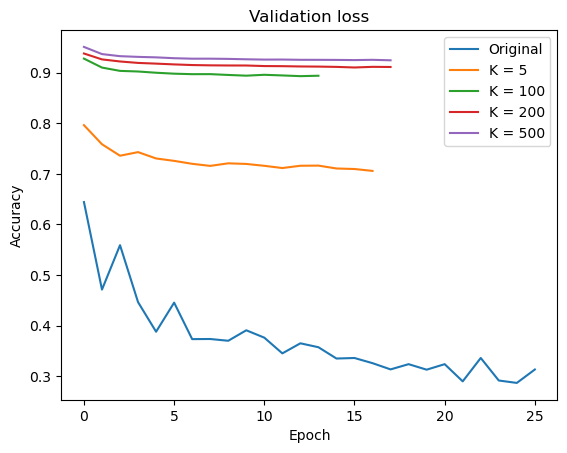

In [16]:
for i in range(len(mond_util.histories)):
    if i == 0:
        plt.plot(mond_util.histories[i].history['loss'], label="Original")
    else:
        plt.plot(mond_util.histories[i].history['loss'], label=f"K = {mond_util.k_list[i-1]}")
plt.title("Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

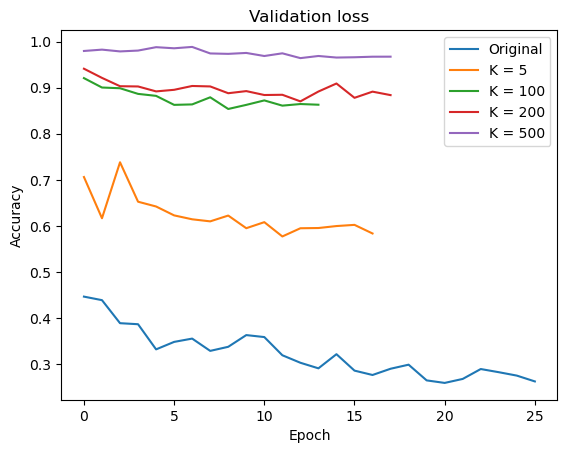

In [15]:
for i in range(len(mond_util.histories)):
    if i == 0:
        plt.plot(mond_util.histories[i].history['val_loss'], label="Original")
    else:
        plt.plot(mond_util.histories[i].history['val_loss'], label=f"K = {mond_util.k_list[i-1]}")
plt.title("Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [37]:
test_accs = {}
for i in range(len(mond_util.k_list) + 1):
    if i == 0:
        mond_util.models[i] = tf.keras.models.load_model("./weights/model_org.h5")
    else:
        mond_util.models[i] = tf.keras.models.load_model(f"./weights/model_{k_list[i-1]}.h5")
    X, y = mond_util.features[i]
    _, X_test, y_test = encodeNonAnonData("adult", "/Users/amirrezasokhankhosh/Documents/Workstation/testing_adult/data/adult/test.csv")
    res = mond_util.models[i].evaluate(X_test, y_test)
    if i == 0:
        test_accs["Original"] = res[1]
    else:
        test_accs[f"K = {k_list[i-1]}"] = res[1]
print(test_accs)

Replacing all generalized values...


15060it [00:00, 26201.83it/s]
2023-11-27 07:50:09.990129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but

471/471 [==============================] - 3s 6ms/step - loss: 2.7224 - accuracy: 0.6398


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x1xi1>'


Replacing all generalized values...


15060it [00:00, 26331.74it/s]


  1/471 [..............................] - ETA: 1:48 - loss: 0.7766 - accuracy: 0.6875

2023-11-27 07:50:14.375858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'


471/471 [==============================] - 3s 6ms/step - loss: 0.9375 - accuracy: 0.6341


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x1xi1>'


Replacing all generalized values...


15060it [00:00, 26450.13it/s]
2023-11-27 07:50:18.593106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but

471/471 [==============================] - 4s 7ms/step - loss: 0.7145 - accuracy: 0.5986


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x1xi1>'


Replacing all generalized values...


15060it [00:00, 24013.97it/s]
2023-11-27 07:50:23.387502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but

471/471 [==============================] - 3s 7ms/step - loss: 0.7231 - accuracy: 0.5614


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x1xi1>'


Replacing all generalized values...


15060it [00:00, 25380.67it/s]


  1/471 [..............................] - ETA: 1:36 - loss: 0.5959 - accuracy: 0.6875

2023-11-27 07:50:27.953302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'


471/471 [==============================] - 3s 6ms/step - loss: 0.6914 - accuracy: 0.5548
{'Original': 0.6397742629051208, 'K = 5': 0.6341301202774048, 'K = 100': 0.5986055731773376, 'K = 200': 0.5613545775413513, 'K = 500': 0.5548473000526428}


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x20x1x1xi1>'


In [103]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from anonymeter.evaluators import SinglingOutEvaluator
from anonymeter.evaluators import LinkabilityEvaluator
from anonymeter.evaluators import InferenceEvaluator

In [104]:
ori = pd.read_csv("./pr_mondrian_results/occupancy_anonymized_org.csv")
control, _, _ = encodeNonAnonData("occupancy", "/Users/amirrezasokhankhosh/Documents/Workstation/testing_adult/data/occupancy/test.csv")

Replacing all generalized values...


861it [00:00, 27960.94it/s]


In [90]:
risks = {}
for k in k_list:
    syn = pd.read_csv(f"./pr_mondrian_results/occupancy_anonymized_{k}.csv")
    evaluator = SinglingOutEvaluator(ori=ori, 
                                    syn=syn, 
                                    control=control,
                                    n_attacks=100, # this attack takes longer
                                    n_cols=4)


    try:
        evaluator.evaluate(mode='multivariate')
        risk = evaluator.risk()
        print(risk.value)
        risks[f"K = {k}"] = risk.value

    except RuntimeError as ex: 
        print(f"Singling out evaluation failed with {ex}. Please re-run this cell."
            "For more stable results increase `n_attacks`. Note that this will "
            "make the evaluation slower.")

0.10918250215256743
0.01740622151333518


/Users/amirrezasokhankhosh/mambaforge/envs/data-science/lib/python3.10/site-packages/anonymeter/stats/confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.028126814121422983, baseline = 0.028126814121422983. Analysis results cannot be trusted.
  self._sanity_check()


0.001844311770318952
0.08059817983799487


/Users/amirrezasokhankhosh/mambaforge/envs/data-science/lib/python3.10/site-packages/anonymeter/stats/confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.04738694415728327, baseline = 0.057017009175213414. Analysis results cannot be trusted.
  self._sanity_check()


0.016244766584956986
0.0415280965743401
0.04102028043938658


In [38]:
test = sorted(test_accs.items(), key=lambda kv: (kv[1], kv[0]))
test_accs = {}
for t in test:
    test_accs[t[0]] = t[1]

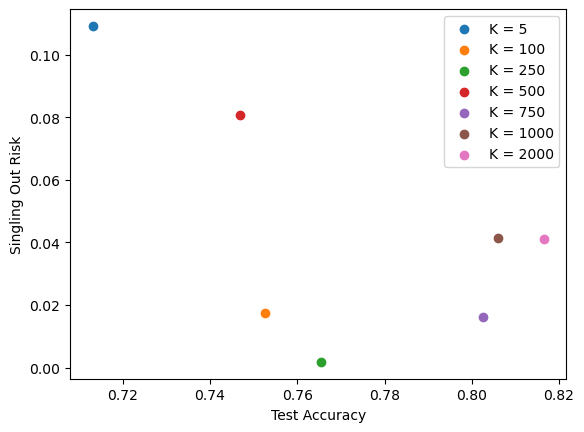

In [92]:
for k in k_list:
    plt.scatter(test_accs[f"K = {k}"], risks[f"K = {k}"], label=f"K = {k}")
plt.ylabel("Singling Out Risk")
plt.xlabel("Test Accuracy")
plt.legend()
plt.show()

In [25]:
test_accs

{'K = 100': 0.624701201915741,
 'Original': 0.6391102075576782,
 'K = 5': 0.6430279016494751}

<BarContainer object of 5 artists>

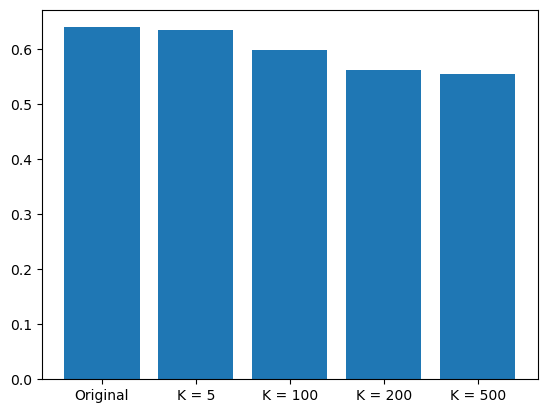

In [39]:
names = ["Original"] + [f"K = {k}" for k in k_list]
height = [test_accs[name] for name in names]
plt.bar(names, height)

In [111]:
from sklearn.metrics import f1_score
import numpy as np
f1s = {}
for i in range(len(mond_util.k_list) + 1):
    if i == 0:
        mond_util.models[i] = tf.keras.models.load_model("./weights/model_org.h5")
    else:
        mond_util.models[i] = tf.keras.models.load_model(f"./weights/model_{k_list[i-1]}.h5")
    X, y = mond_util.features[i]
    _, X_test, y_test = encodeNonAnonData("occupancy", "/Users/amirrezasokhankhosh/Documents/Workstation/testing_adult/data/occupancy/test.csv")
    pred = mond_util.models[i].predict(X_test)
    f1 = f1_score(y_test, pred>0.5, average='weighted')
    print(f1)
    if i == 0:
        f1s["Original"] = f1
    else:
        f1s[f"K = {k_list[i-1]}"] = f1
# print(f1s)

Replacing all generalized values...


861it [00:00, 28388.46it/s]

27/27 [==============================] - 0s 3ms/step
0.6817690143297375



2023-11-26 23:44:30.772430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Replacing all generalized values...


861it [00:00, 28405.43it/s]

27/27 [==============================] - 0s 3ms/step
0.67082258735795



2023-11-26 23:44:31.025067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Replacing all generalized values...


861it [00:00, 28371.73it/s]

27/27 [==============================] - 0s 3ms/step



2023-11-26 23:44:31.295302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.7012329333814965
Replacing all generalized values...


861it [00:00, 27209.06it/s]

27/27 [==============================] - 0s 3ms/step



2023-11-26 23:44:31.577586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.6588048663843884
Replacing all generalized values...


861it [00:00, 28359.70it/s]

27/27 [==============================] - 0s 3ms/step



2023-11-26 23:44:31.844527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.683367511010111
Replacing all generalized values...


861it [00:00, 28395.38it/s]

27/27 [==============================] - 0s 3ms/step



2023-11-26 23:44:32.105572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.6657236902228004
Replacing all generalized values...


861it [00:00, 28650.39it/s]

27/27 [==============================] - 0s 3ms/step



2023-11-26 23:44:32.378703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.6836894232364615
Replacing all generalized values...


861it [00:00, 27425.62it/s]

27/27 [==============================] - 0s 3ms/step



2023-11-26 23:44:32.635863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.7215795586527294
Replacing all generalized values...


861it [00:00, 28442.12it/s]

27/27 [==============================] - 0s 3ms/step
0.7264940774116908



2023-11-26 23:44:32.892648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<BarContainer object of 9 artists>

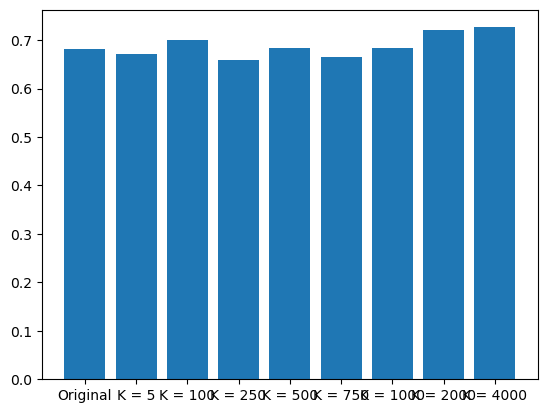

In [112]:
names = ["Original"] + [f"K = {k}" for k in k_list]
height = [f1s[name] for name in names]
plt.bar(names, height)

In [ ]:
# Make it work for adult
# See syn for occ